In [4]:
import os
import pickle
import random
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy.ndimage import median_filter, binary_dilation
import scipy.signal
from scipy.spatial.distance import pdist, squareform
import ruptures as rpt

In [5]:
def load_pickles(directory):
    """Load pickle files from a directory."""
    all_data = {}
    for filename in filter(lambda f: f.endswith('.pkl'), os.listdir(directory)):
        song_id = filename.split('_')[0]
        with open(os.path.join(directory, filename), 'rb') as file:
            all_data[song_id] = pickle.load(file)
    return all_data

def find_max_frames_and_measures(all_segments):
    """Find the maximum number of frames per measure and measures."""
    max_frames = max(max(len(m[0]) for m in s) for s in all_segments.values())
    max_measures = max(len(s) for s in all_segments.values())
    return max_frames, max_measures

def pad_measures(all_segments, max_frames):
    """Pad measures to have the same number of frames."""
    return {song_id: [np.pad(m[0], ((0, max_frames - m[0].shape[0]), (0, 0)), 'constant') for m in song]
            for song_id, song in all_segments.items()}

def pad_songs(padded_measures, max_measures, max_frames, n_features=32):
    """Pad songs to have the same number of measures."""
    padding_measure = np.zeros((max_frames, n_features))
    return {song_id: song + [padding_measure] * (max_measures - len(song))
            for song_id, song in padded_measures.items()}

def pad_labels(all_labels, max_measures):
    """Pad labels to have the same number of measures."""
    return {song_id: np.pad(labels, (0, max_measures - len(labels)), 'constant', constant_values=-1)
            for song_id, labels in all_labels.items()}

def split_data(padded_songs, padded_labels):
    """Split data into training, validation, and test sets."""
    song_ids = list(padded_songs.keys())
    _, temp_ids = train_test_split(song_ids, test_size=0.3, random_state=42)
    _, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)
    # Only create test data and labels
    test_data = {song_id: padded_songs[song_id] for song_id in test_ids}
    test_labels = {song_id: padded_labels[song_id] for song_id in test_ids}
    return test_data, test_labels

def data_generator(X, y):
    """Yield batches of data."""
    for song_id in X:
        yield np.array(X[song_id]), np.expand_dims(y[song_id], axis=-1)

def create_dataset(X, y, batch_size):
    """Create a TensorFlow dataset from the generator function."""
    return tf.data.Dataset.from_generator(
        lambda: data_generator(X, y),
        output_signature=(
            tf.TensorSpec(shape=(None, None, 32), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 1), dtype=tf.float32)
        )
    ).batch(batch_size)

def custom_binary_crossentropy(y_true, y_pred):
    """Calculate the binary crossentropy, ignoring masked values."""
    y_true = tf.cast(y_true, tf.float32)
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    return tf.reduce_sum(tf.keras.backend.binary_crossentropy(y_true, y_pred) * mask) / tf.reduce_sum(mask)

def custom_accuracy(y_true, y_pred):
    """Calculate the accuracy, ignoring masked values."""
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    correct_predictions = tf.cast(tf.equal(tf.round(y_pred), y_true), tf.float32)
    return tf.reduce_sum(correct_predictions * mask) / tf.reduce_sum(mask)

def calculate_ki_chroma(waveform, sr):
    """Calculate a key-invariant chromagram for a given audio waveform."""
    chromagram = librosa.feature.chroma_cqt(y=waveform, sr=sr, bins_per_octave=24)
    chroma_vals = np.sum(chromagram, axis=1)
    maj_profile = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
    min_profile = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])
    maj_corrs = [np.corrcoef(np.roll(chroma_vals, -i), maj_profile)[0, 1] for i in range(12)]
    min_corrs = [np.corrcoef(np.roll(chroma_vals, -i), min_profile)[0, 1] for i in range(12)]
    max_corr_idx = np.argmax(maj_corrs + min_corrs)
    key_shift = max_corr_idx % 12
    return np.roll(chromagram, -key_shift, axis=0)

def find_anchor_frame(beats, tempo, sr):
    """Find the anchor frame for beat tracking."""
    expected_interval = librosa.time_to_frames(60.0 / tempo, sr=sr)
    best_match_start = max((1 - abs(np.mean(beats[i:i+3]) - expected_interval) / expected_interval, beats[i])
                           for i in range(len(beats) - 2))[1]
    return best_match_start if best_match_start > 0.95 else beats[0]

def create_measure_grid(beats, anchor_frame, beat_interval_in_frames, time_signature, duration_in_frames):
    """Create a grid of beats and measures."""
    beat_grid = [anchor_frame or beats[0]]
    beat_grid.extend(range(beat_grid[0] - beat_interval_in_frames, -1, -beat_interval_in_frames))
    measure_grid = list(range(0, duration_in_frames + 1, beat_interval_in_frames * time_signature))
    return np.array(measure_grid)

def detect_novelty_boundaries(ssm, measure_interval_in_frames, lag=4, sigma=15, prominence=0.002):
    """
    Detect novelty boundaries in a self-similarity matrix.
    """
    novelty_curve_lag = np.abs(np.diff(np.diag(ssm, k=lag), prepend=0))
    smoothed_novelty_lag = scipy.ndimage.gaussian_filter1d(novelty_curve_lag, sigma=sigma)
    
    # Calculate the exclusion zone length
    exclusion_zone_length = measure_interval_in_frames * 4
    
    # Modify the start and end of the smoothed_novelty_lag to prevent peak detection in these regions
    smoothed_novelty_lag[:exclusion_zone_length] = 0
    smoothed_novelty_lag[-exclusion_zone_length:] = 0
    
    # Find peaks in the smoothed novelty curve with adjusted parameters
    novelty_distance = measure_interval_in_frames
    peaks_lag, _ = scipy.signal.find_peaks(smoothed_novelty_lag, prominence=prominence, distance=novelty_distance)
    
    return peaks_lag

def apply_measure_grid(ax, measure_grid_times):
    """Apply measure grid lines to a matplotlib axis."""
    for time in measure_grid_times:
        ax.axvline(x=time, color='grey', linestyle='--', linewidth=1, alpha=0.6)

def highlight_predictions(ax, predictions, true_labels, measure_grid_times):
    """Highlight predictions on a matplotlib axis."""
    colors = {'Correct Chorus': 'limegreen', 'False Positive': 'fuchsia', 'False Negative': 'gold'}
    legend_added = {key: False for key in colors.keys()}

    for i, (pred, true) in enumerate(zip(predictions, true_labels)):
        start_time, end_time = measure_grid_times[i], measure_grid_times[i + 1]
        if pred == true:
            color, label = colors['Correct Chorus'], 'Correct Chorus' if not legend_added['Correct Chorus'] else ""
            legend_added['Correct Chorus'] = True
        elif pred:
            color, label = colors['False Positive'], 'False Positive' if not legend_added['False Positive'] else ""
            legend_added['False Positive'] = True
        elif true:
            color, label = colors['False Negative'], 'False Negative' if not legend_added['False Negative'] else ""
            legend_added['False Negative'] = True
        else:
            continue
        ax.axvspan(start_time, end_time, color=color, alpha=0.3, label=label)
        
def format_time(time_in_seconds):
    """Convert time in seconds to m:ss format."""
    minutes = int(time_in_seconds // 60)
    seconds = int(time_in_seconds % 60)
    return f"{minutes}:{seconds:02d}"

# Generate test dataset

In [9]:
# Path to the pickled files
x_test_path = '../data/pkl/test_data.pkl'
y_test_path = '../data/pkl/test_labels.pkl'

# Load X_test
with open(x_test_path, 'rb') as file:
    X_test = pickle.load(file)

# Load y_test
with open(y_test_path, 'rb') as file:
    y_test = pickle.load(file)

In [7]:
# Directories containing the pickled files
segment_dir = "../data/pkl/segments"
labels_dir = "../data/pkl/labels"

# Load all segments and labels
all_segments = load_pickles(segment_dir)
all_labels = load_pickles(labels_dir)

# Find the maximum frames per measure and maximum measures across all songs
max_frames_per_measure, max_measures = find_max_frames_and_measures(all_segments)

# Pad measures within each song and then pad all songs to have the same number of measures
padded_measures = pad_measures(all_segments, max_frames_per_measure)
padded_songs = pad_songs(padded_measures, max_measures, max_frames_per_measure)

# Pad labels to match the structure of padded_segments
padded_labels = pad_labels(all_labels, max_measures)

# Get only the test data and labels
X_test, y_test = split_data(padded_songs, padded_labels)

# Create the test dataset
batch_size = 32
test_dataset = create_dataset(X_test, y_test, batch_size)

del(all_segments, all_labels, padded_measures, padded_songs, padded_labels)

In [10]:
# Load a random song's features and audio, and compute the measure grid
random_song_id = random.choice(list(X_test.keys()))
df = pd.read_csv('../data/dataframes/clean_labeled.csv')
data = df.loc[df['SongID'] == int(random_song_id)] 

# Load the audio file
y, sr = librosa.load(f'../data/audio_files/processed/{random_song_id}.mp3', sr=None)

rms = librosa.feature.rms(y=y)
rms = np.array(rms.flatten())
chroma = calculate_ki_chroma(y, sr)

# Compute onset envelope from Constant-Q transform
C = librosa.cqt(y=y, sr=sr)
S_dB = librosa.amplitude_to_db(np.abs(C), ref=np.max)
onset_env = librosa.onset.onset_strength(sr=sr, S=S_dB)

# Compute tempo, beat envelope, and tempogram ratio
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
beats_aligned = librosa.util.fix_frames(beats, x_max=chroma.shape[1])
tgr = librosa.feature.tempogram_ratio(tg=librosa.feature.tempogram(onset_envelope=onset_env, sr=sr), sr=sr)
chroma_sync = librosa.util.sync(chroma, beats_aligned, aggregate=np.mean)

# Retrieve or estimate tempo and time signature from the data
bpm = data['sp_tempo'].fillna(tempo).replace(0, tempo).clip(lower=70, upper=140).iloc[0]
time_signature = int(data['sp_time_signature'].fillna(4).replace(0, 4).iloc[0])

# Compute the measure grid
beat_interval_in_frames = librosa.time_to_frames(60/bpm, sr=sr)
measure_interval_in_frames = beat_interval_in_frames * time_signature
duration_in_frames = len(S_db.T)
anchor_frame = find_anchor_frame(beats, bpm, sr)
measure_grid = create_measure_grid(beats, anchor_frame, beat_interval_in_frames, time_signature, duration_in_frames)

NameError: name 'S_db' is not defined

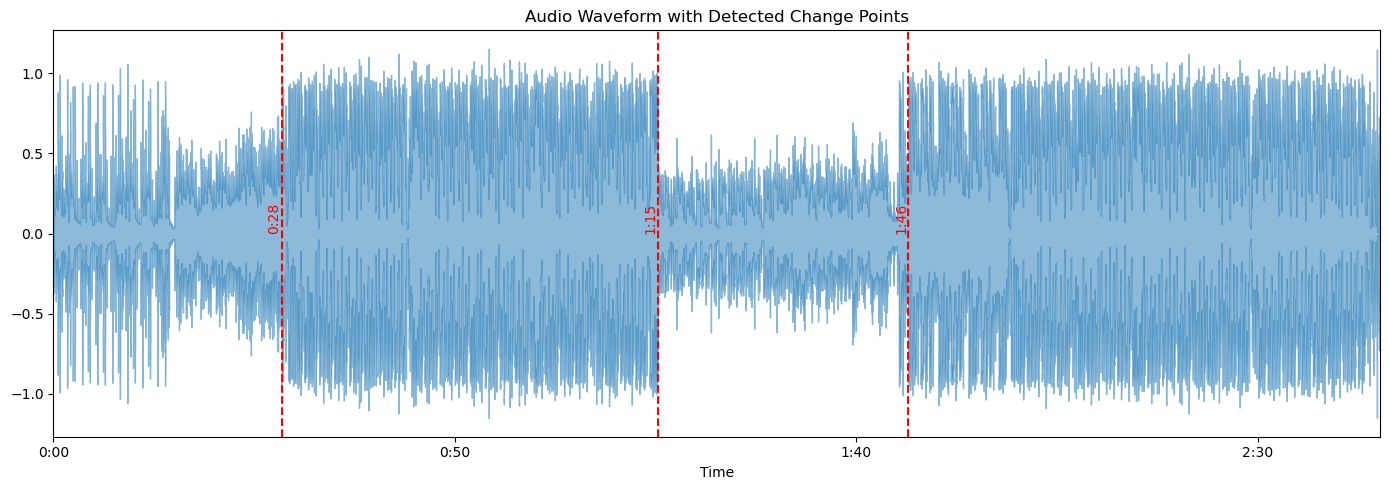

In [202]:
def detect_change_points(data, penalty_lambda):
    algo = rpt.Pelt(model="l2").fit(data)
    change_points = algo.predict(pen=penalty_lambda)
    if change_points:  
        return change_points[:-1]
    else:
        return change_points

start_index, end_index = int(librosa.time_to_frames(5, sr=sr)), len(rms) - int(librosa.time_to_frames(5, sr=sr))
penalty = 2 * np.log(len(rms[start_index:end_index]))  
segments = detect_change_points(rms[start_index:end_index], penalty)

# Add start_index to segment indices to adjust them back to the global context
global_segments = [s + start_index for s in segments]

# Convert segment frame indices to time for plotting
segment_times = librosa.frames_to_time(global_segments, sr=sr, hop_length=512)  # Ensure hop_length matches your RMS calculation

# Plot the waveform using librosa.display.waveshow
fig, ax = plt.subplots(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr, alpha=0.5)

# Overlay the segments on the waveform
for time in segment_times:
    plt.axvline(x=time, color='r', linestyle='--')
    formatted_time = format_time(time)
    plt.text(time, 0, f'{formatted_time}', rotation=90, color='red', ha='right', va='bottom', fontsize=10)

ax.set_xlim([0, librosa.get_duration(y=y, sr=sr)])
plt.title('Audio Waveform with Detected Change Points')
plt.tight_layout()
plt.show()

In [203]:
# Compute the chromagram
chroma = calculate_ki_chroma(y, sr)
beats_aligned = librosa.util.fix_frames(beats, x_max=chroma.shape[1])
chroma_sync = librosa.util.sync(chroma, beats_aligned, aggregate=np.mean)
chroma_smooth = scipy.ndimage.median_filter(chroma_sync, size=(1, beat_interval_in_frames))

# Sparsify the smoothed chromagram
threshold = 0.02  # Adjust the threshold based on your specific needs
chroma_sparse = librosa.util.sparsify_rows(chroma_smooth, quantile=threshold)

# Convert the sparse matrix to a dense format
chroma_dense = chroma_sparse.toarray() if scipy.sparse.issparse(chroma_sparse) else chroma_sparse

# Ensure that chroma_dense has enough frames to compute the recurrence matrix
if chroma_dense.shape[1] >= 3:  # The shape along the time axis must be at least 3
    rec = librosa.segment.recurrence_matrix(chroma_dense, mode='affinity', sym=True)
    rec_smooth = librosa.segment.path_enhance(rec, 51, window='hann', n_filters=7)
else:
    raise ValueError("The chromagram does not have enough frames to compute the recurrence matrix.")

KeyboardInterrupt: 

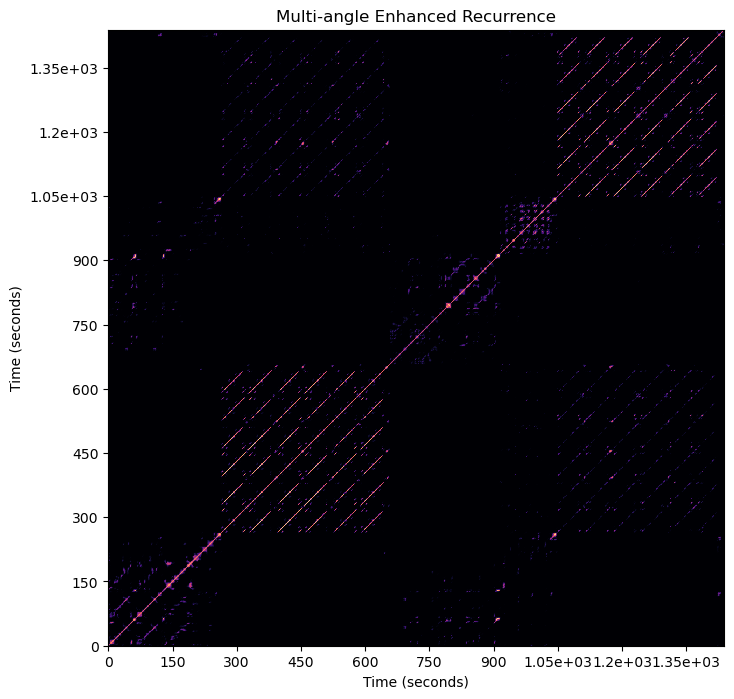

In [195]:
# Plot the multi-angle enhanced recurrence matrix
fig, ax = plt.subplots(figsize=(8, 8))
imgpe = librosa.display.specshow(rec_smooth, x_axis='s', y_axis='s', hop_length=hop_length, ax=ax)
ax.set(title='Multi-angle Enhanced Recurrence')
plt.show()

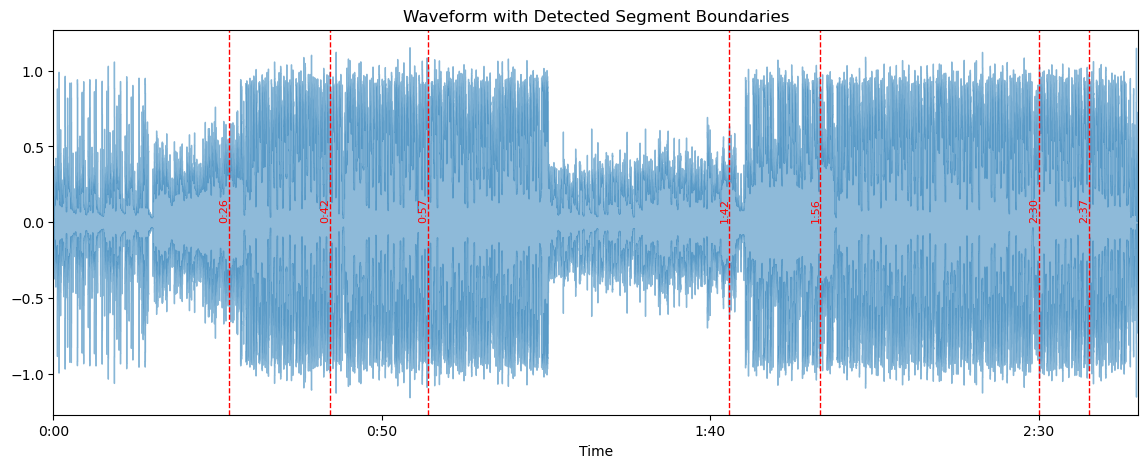

In [200]:
# Sum or average the enhanced recurrence matrix across rows
similarity_sum = np.sum(rec_smooth, axis=1)
similarity_gradient = np.abs(np.gradient(similarity_sum))
threshold = np.std(similarity_gradient) * 5  # Example threshold
boundary_indices = np.where(similarity_gradient > threshold)[0]
dilated = binary_dilation(similarity_gradient > threshold, structure=np.ones((measure_interval_in_frames*4,)))  # Example structure size; adjust as needed
refined_boundaries = np.diff(dilated.astype(int), prepend=0, append=0)

boundary_indices_refined = np.where(refined_boundaries == 1)[0]
boundary_times = librosa.frames_to_time(boundary_indices_refined, sr=sr)
# Plot the waveform using librosa.display.waveshow
fig, ax = plt.subplots(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr, alpha=0.5, ax=ax)

# Overlay boundary times on the waveform
for time in boundary_times:
    ax.axvline(x=time, color='r', linestyle='--', linewidth=1)
    formatted_time = format_time(time)
    plt.text(time, 0, f'{formatted_time}', rotation=90, color='red', ha='right', va='bottom', fontsize=8)
ax.set(title='Waveform with Detected Segment Boundaries')
ax.set_xlim([0, librosa.get_duration(y=y, sr=sr)])
plt.show()


In [173]:
boundary_times

array([102.35733333, 413.696     , 619.94666667])

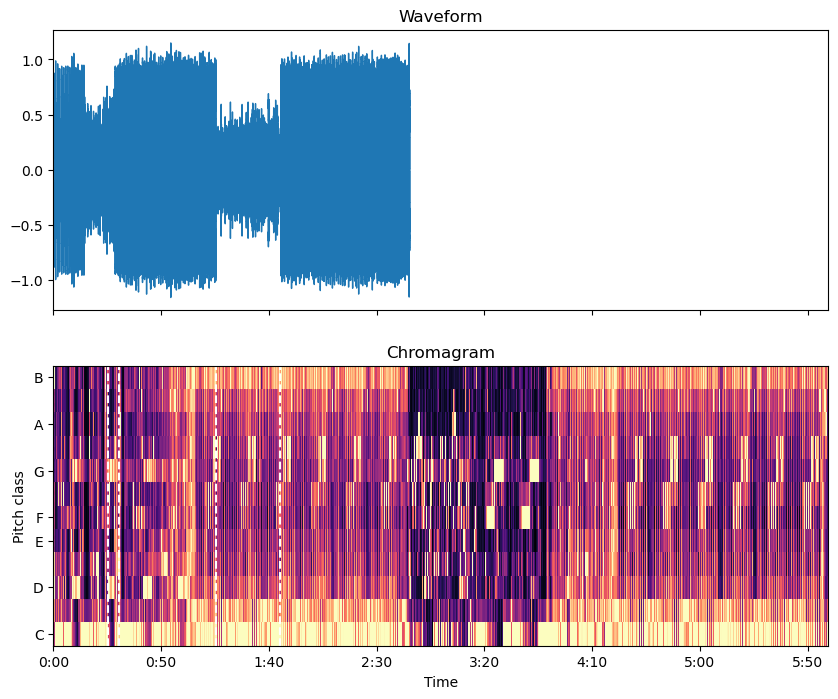

In [141]:
# Agglomerative clustering
boundaries = librosa.segment.agglomerative(chroma, k=5)  # Adjust 'k' as needed
seg_times = librosa.frames_to_time(boundaries, sr=sr)

# Plotting the results
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))
librosa.display.waveshow(y, sr=sr, ax=ax[0])
ax[0].set(title='Waveform')
ax[0].label_outer()

librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax[1])
ax[1].set(title='Chromagram')
for t in seg_times:
    ax[1].axvline(x=t, color='white', linestyle='--')

plt.show()

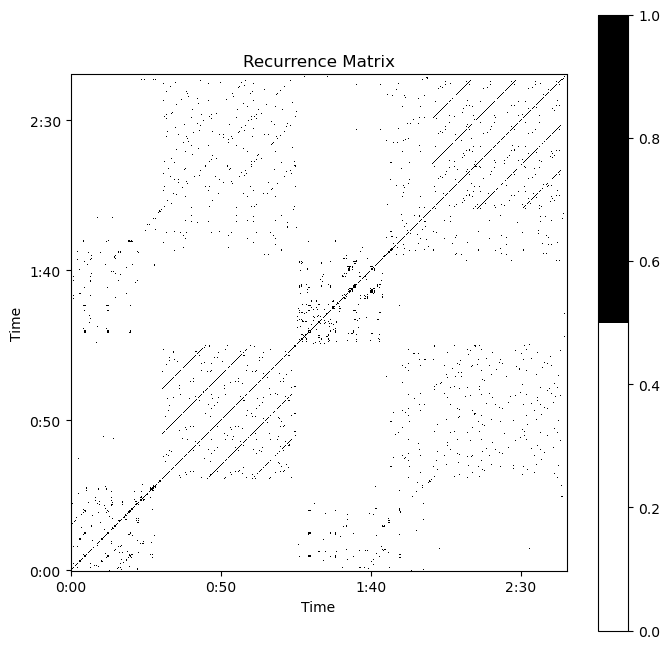

In [142]:
# Compute the recurrence matrix
rec_matrix = librosa.segment.recurrence_matrix(chroma, sym=True)

# Plot the recurrence matrix
plt.figure(figsize=(8, 8))
librosa.display.specshow(rec_matrix, x_axis='time', y_axis='time', sr=sr, hop_length=512)
plt.title('Recurrence Matrix')
plt.colorbar()
plt.show()


In [ ]:
# Define custom objects
custom_objects = {
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
}

model_dir = os.path.join('..', 'models', 'CRNN')
best_model_filepath = os.path.join(model_dir, 'best_model.h5')

# Load the saved model with the custom objects
model = load_model(best_model_filepath, custom_objects=custom_objects)


In [ ]:
# Define custom objects
custom_objects = {
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
}

model_dir = os.path.join('..', 'models', 'CRNN')
best_model_filepath = os.path.join(model_dir, 'best_model.h5')

# Load the saved model with the custom objects
model = load_model(best_model_filepath, custom_objects=custom_objects)

# Get the corresponding test data and label
test_song = np.array(X_test[random_song_id], dtype=np.float32)
test_label = np.array(y_test[random_song_id], dtype=np.float32)
# Generate predictions for the selected song
# Reshape the song data to match the expected input shape of the model
test_song_reshaped = np.expand_dims(test_song, axis=0)
predictions = model.predict(test_song_reshaped)
predictions = predictions.flatten() > 0.5  # Apply threshold to get binary results

num_measures = len(measure_grid)-1
unpadded_predictions = predictions[:num_measures]

# Convert chorus start and end frames to a binary array of true labels
true_labels = np.zeros(num_measures, dtype=bool)
choruses = data.loc[data['label'] == 'chorus']
for index, chorus in choruses.iterrows():
    start_time = librosa.frames_to_time(chorus['start_frame'], sr=sr)
    end_time = librosa.frames_to_time(chorus['end_frame'], sr=sr)
    # Find the measures that the chorus spans
    for measure_index, (measure_start, measure_end) in enumerate(zip(measure_grid_times[:-1], measure_grid_times[1:])):
        if start_time < measure_end and end_time > measure_start:
            true_labels[measure_index] = True
            
    
# Generate the plot
fig, ax = plt.subplots(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr, color='b', alpha=0.5)
ax.set_xlim([0, len(y) / sr])
apply_measure_grid(ax, measure_grid_times)

highlight_predictions(ax, unpadded_predictions, true_labels, measure_grid_times, sr)

ax.set_ylabel('Amplitude')
ax.set_title(f'Song {random_song_id} Predictions')

# Create the legend
handles, labels = ax.get_legend_handles_labels()
# Filter out any extra handles
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique), loc='best')

plt.show()

,SongID,start_time,end_time,start_frame,end_frame,label,TrackName,Artists,Genre,FilePath,...,sp_loudness,sp_speechiness,sp_acousticness,sp_instrumentalness,sp_liveness,sp_valence,sp_tempo,sp_time_signature,sp_genre,sampling_rate


In [19]:
df.loc[df['SongID'] == int(random_song_id)]

,SongID,start_time,end_time,start_frame,end_frame,label,TrackName,Artists,Genre,FilePath,...,sp_loudness,sp_speechiness,sp_acousticness,sp_instrumentalness,sp_liveness,sp_valence,sp_tempo,sp_time_signature,sp_genre,sampling_rate
905,283,0.0,69.700000,0,6534,other,Hostyl,"Malaa, Dombresky",Bass House,..\data\audio_files\processed\283.mp3,...,-2.245,0.0543,0.0455,0.763,0.0662,0.266,123.993,4.0,"electronic trap, edm, bass house, house, tech ...",48000
906,283,69.7,100.600000,6534,9431,chorus,Hostyl,"Malaa, Dombresky",Bass House,..\data\audio_files\processed\283.mp3,...,-2.245,0.0543,0.0455,0.763,0.0662,0.266,123.993,4.0,"electronic trap, edm, bass house, house, tech ...",48000
907,283,100.6,139.300000,9431,13059,other,Hostyl,"Malaa, Dombresky",Bass House,..\data\audio_files\processed\283.mp3,...,-2.245,0.0543,0.0455,0.763,0.0662,0.266,123.993,4.0,"electronic trap, edm, bass house, house, tech ...",48000
908,283,139.3,185.800000,13059,17418,chorus,Hostyl,"Malaa, Dombresky",Bass House,..\data\audio_files\processed\283.mp3,...,-2.245,0.0543,0.0455,0.763,0.0662,0.266,123.993,4.0,"electronic trap, edm, bass house, house, tech ...",48000
909,283,185.8,217.188027,17418,20361,other,Hostyl,"Malaa, Dombresky",Bass House,..\data\audio_files\processed\283.mp3,...,-2.245,0.0543,0.0455,0.763,0.0662,0.266,123.993,4.0,"electronic trap, edm, bass house, house, tech ...",48000


In [18]:
X_test.keys()

dict_keys(['241', '129', '12', '208', '275', '283', '54', '281', '212', '140', '214', '353', '8', '234', '457', '182', '229', '26', '7', '56', '472', '374', '498', '450', '501', '2', '151', '107', '403', '476', '10', '165', '78', '349', '185', '351', '186', '465', '37', '279', '71', '453', '36', '127', '88', '410', '307', '269', '493', '294'])

In [ ]:
df